In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.axis import Axis
from datetime import datetime, timedelta
from dataclasses import dataclass, field
from sklearn.linear_model import LinearRegression
import re

In [25]:
class Run:
    df: pd.DataFrame
    units = {}

    def __init__(self, df: pd.DataFrame):
        self.df = df

        for column in self.df.columns:
            setattr(self, column, self.df[column])

    @property
    def properties(self) -> list[str]:
        return list(self.df.columns)

    def plot(self, x: str | pd.Series, y: str | pd.Series, axis: Axis = None):
        if isinstance(x, str):
            x = self.df[x]
        if isinstance(y, str):
            y = self.df[y]
        if axis:
            ax = axis
        else:
            fig, ax = plt.subplots()
            
        ret = []
        ax.plot(x, y)
        
        if x.name == 't':
            if y.name == 'v':
                max_idx = y.idxmax()
                front = y[:max_idx]
                diff = abs(front - front.iloc[0])
                min_idx = diff[diff < 0.01].index[-1]

                rectangle = patches.Rectangle(
                    xy=(x[min_idx], y[min_idx]),
                    width=x[max_idx] - x[min_idx],
                    height=y[max_idx] - y[min_idx],
                    linewidth=3, edgecolor='orange', facecolor='orange', alpha=0.2
                )

                x_space = x[min_idx - 2:max_idx - 1].to_numpy()
                y_space = y[min_idx - 2:max_idx - 1].to_numpy()

                # 선형 회귀하기
                w = (y_space[-1] - y_space[0]) / (x_space[-1] - x_space[0])
                b = y_space[0]

                ax.plot(x_space, w * (x_space - x_space[0]) + b, color='orange', linewidth=2)
                ax.text(0, -0.04, f'y = {w:.5f}x + {b}', color='orange', fontsize=15)
                ax.add_patch(rectangle)
                
                ret = [w, b]
            elif y.name == 'F':
                peak_idx = y[abs(y.iloc[0] - y) > 0.1].index[0]
                front = y[:peak_idx - 10]

                # 평균값 찾기
                mean = front.mean()
                
                ax.axvspan(x[y.index[0]], x[peak_idx], color='orange', alpha=0.2)
                ax.axhline(mean, color='orange', linewidth=2)
                ax.text(0, mean + 0.04, f'y = {mean:.5f}', color='orange', fontsize=15)
                
                ret = [mean]
        
        ax.set_title(f'{y.name}-{x.name} graph', fontsize=20)
        ax.set_xlabel(x.name + " " + self.units[x.name], fontsize=15)
        ax.set_ylabel(y.name + " " + self.units[y.name], fontsize=15)

        if not axis:
            plt.show()

        return ret


class Runs:
    def __init__(self, path: str = None, runs=None) -> None:
        if runs is not None:
            self.runs = runs
            return

        data = pd.read_csv(path)
        data = data[
            [c for c in data.columns if not (c.startswith('일시') or c.startswith('net') or c.startswith('acc'))]].dropna(
            axis=0, how='all')

        self.runs = {}
        for column in data.columns:
            matched = re.match(r'([a-zA-Zㄱ-힣, ]+) (\(.*\)) (?:Run|실행) (\d+)', column)

            if not matched:
                continue

            name = matched.group(1)
            unit = matched.group(2)
            run_id = int(matched.group(3))

            if run_id not in self.runs:
                self.runs[run_id] = pd.DataFrame(columns=['t', 'F', 'x', 'v', 'a'])

            ko_2_en = {
                '시간': 't',
                '힘': 'F',
                '위치': 'x',
                '속도': 'v',
                '가속도, 파랑': 'a'
            }
            
            self.runs[run_id][ko_2_en[name]] = data[column]
            Run.units[ko_2_en[name]] = unit

        for i in self.runs:
            self.runs[i] = Run(self.runs[i].dropna(axis=0, how='any'))

    def items(self):
        return self.runs.items()

    @property
    def indexes(self):
        return self.runs.keys()

    def __len__(self):
        return len(self.runs)

    def __getitem__(self, key: int | list):
        if isinstance(key, list) or isinstance(key, np.ndarray) or isinstance(key, tuple):
            return Runs(runs={k: self.runs[k] for k in key})
        elif isinstance(key, int):
            return self.runs[key]

    def analyze(self, massbar, weight) -> np.array:
        # with plt.ioff():
        fig, ax = plt.subplots(len(self), 2, figsize=(14, 7 * len(self)))
        
        # fig, ax = plt.subplots(len(self), 1, figsize=(5, 5 * len(self)))
        ret = pd.DataFrame(columns=['N', 'a'])
        # ret = pd.DataFrame(columns=['a'])

        for i, run_id in enumerate(self.runs.keys()):
            run = self.runs[run_id]
            w, b = run.plot(x='t', y='v', axis=ax[i, 0])
            N, = run.plot(x='t', y='F', axis=ax[i, 1])
            ret.loc[run_id] = [N, w]

        plt.savefig(f"./imgs/mass{massbar}-{weight}.png")
        print(f"./imgs/mass{massbar}-{weight}.png saved")
        # plt.show()
        return ret


In [26]:
runs = Runs('./data/저장된 데이터.csv')

def get(runs, massbar=0, weight=0):
    map_list = [
        [(1, 2, 3),
         (4, 5, 6),
         (7, 8, 9),
         (11, 12, 14),
         (15, 16, 18)],
        [(19, 20, 21),
         (22, 23, 24),
         (25, 26, 27),
         (28, 29, 30),
         (31, 32, 33)],
        [(34, 35, 36),
         (37, 38, 39),
         (41, 42, 43),
         (44, 45, 46),
         (47, 48, 50)]
    ]
    
    return runs[map_list[massbar][weight // 10 - 1]]

./imgs/mass0-10.png saved
./imgs/mass0-20.png saved
./imgs/mass0-30.png saved
./imgs/mass0-40.png saved
./imgs/mass0-50.png saved
./imgs/mass1-10.png saved
./imgs/mass1-20.png saved
./imgs/mass1-30.png saved
./imgs/mass1-40.png saved
./imgs/mass1-50.png saved
./imgs/mass2-10.png saved
./imgs/mass2-20.png saved
./imgs/mass2-30.png saved
./imgs/mass2-40.png saved
./imgs/mass2-50.png saved


,N,a
1,-0.379375,0.491831
2,-0.373165,0.512727
3,-0.375962,0.517931
4,-0.294444,0.835238
5,-0.280685,0.805385
6,-0.289348,0.829600
7,-0.197414,1.125581
8,-0.224118,1.116000
9,-0.220278,1.122857
11,-0.147857,1.424242


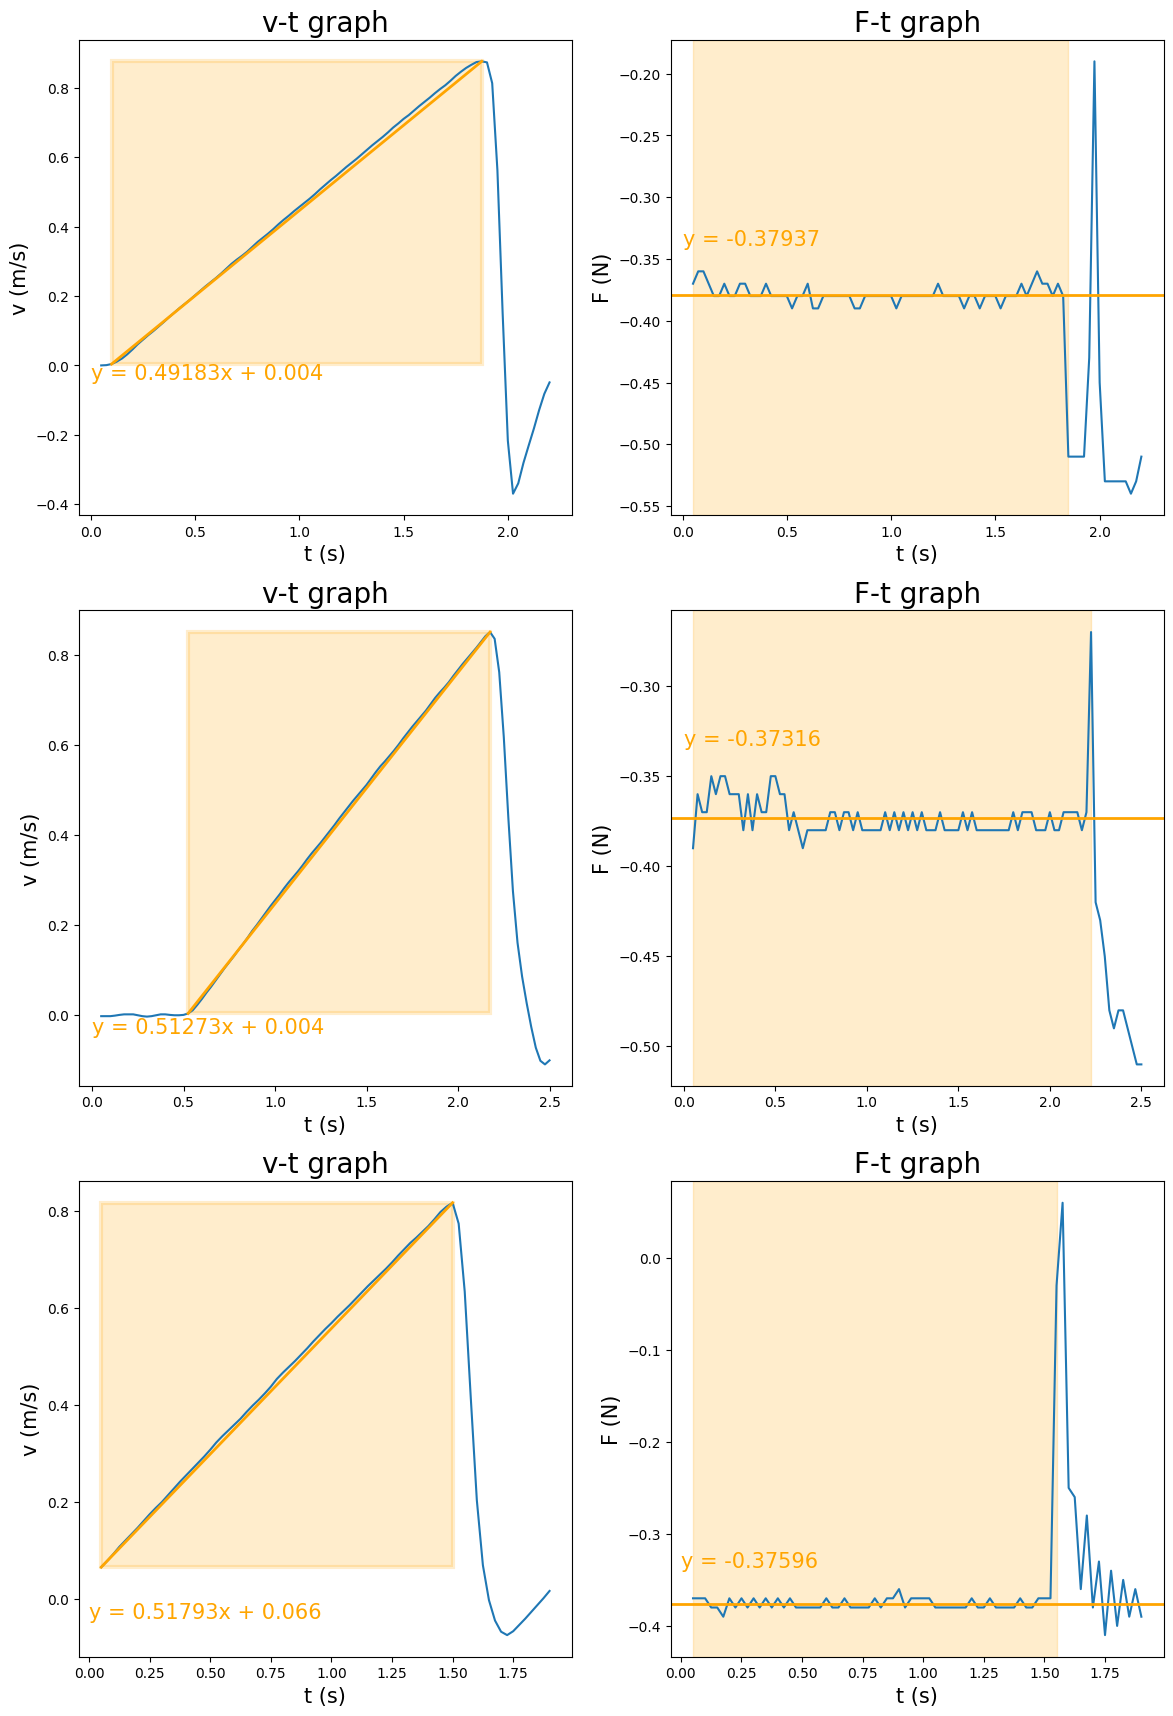

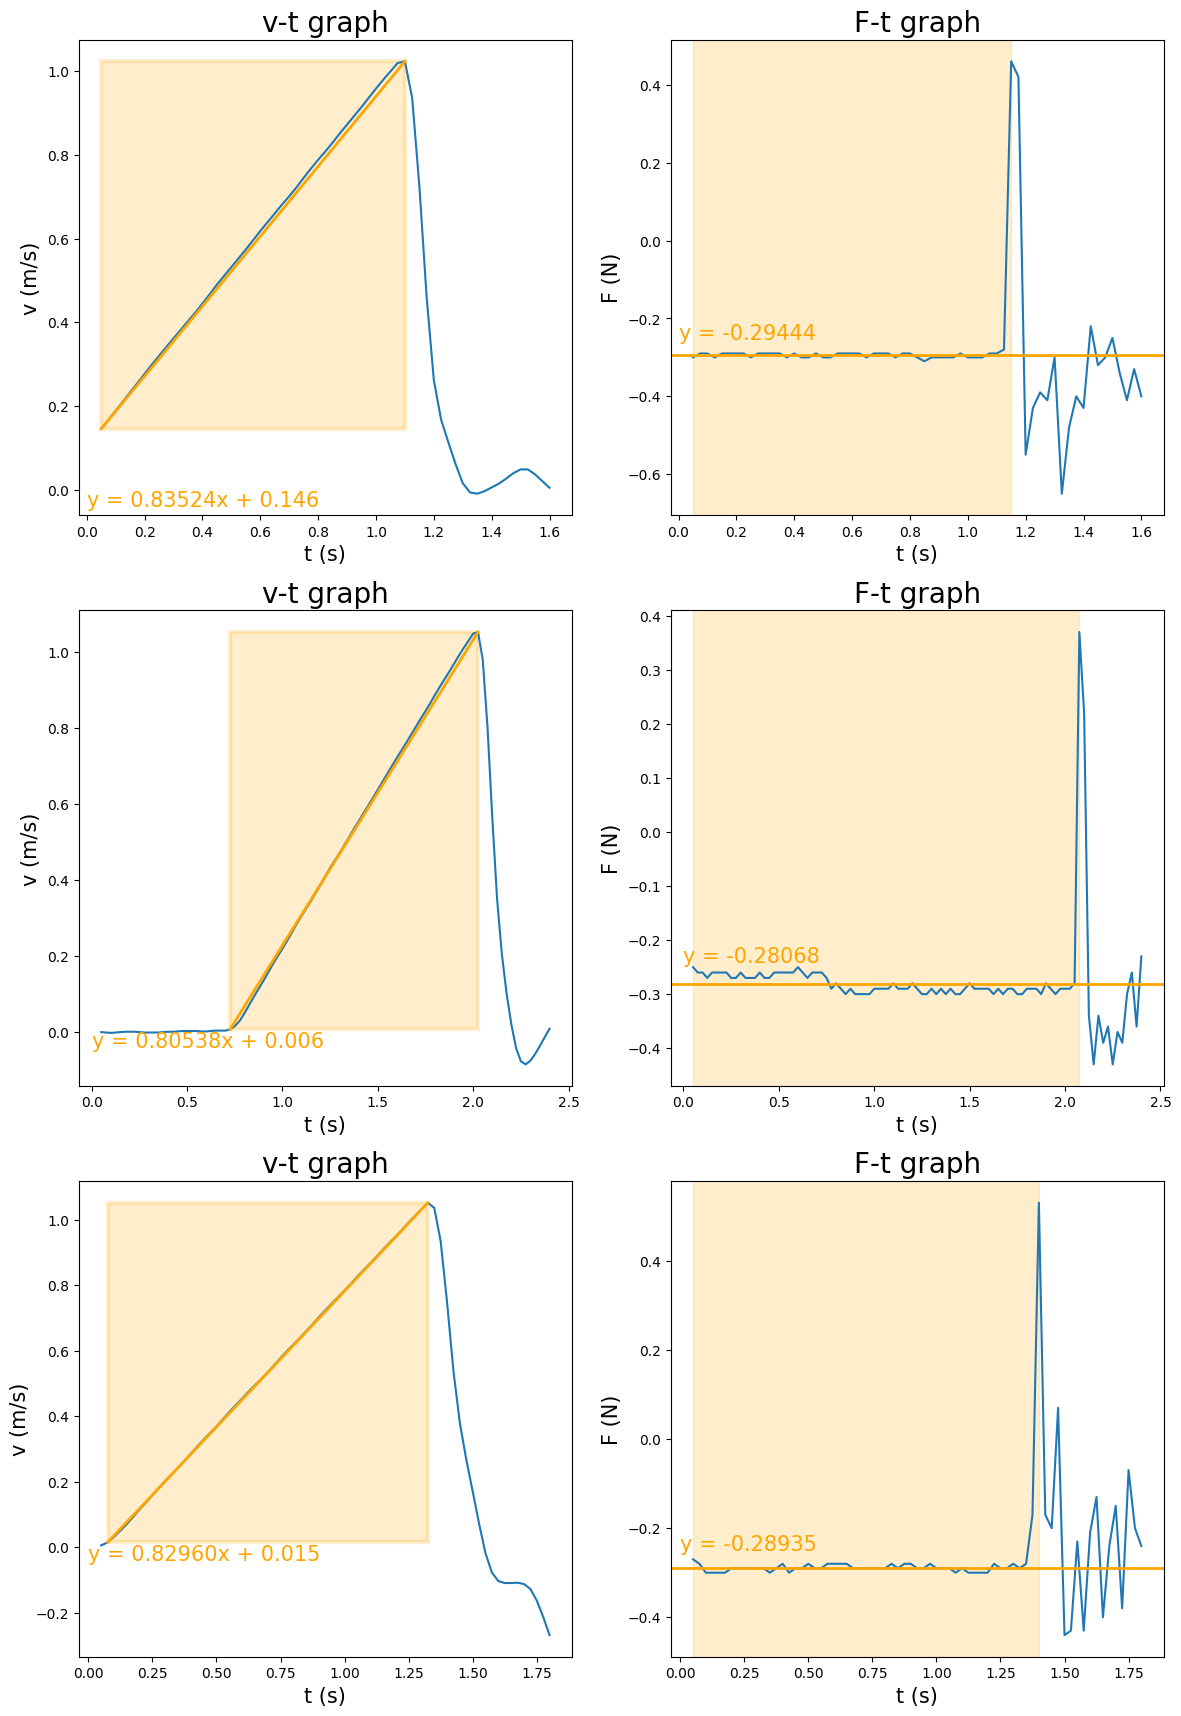

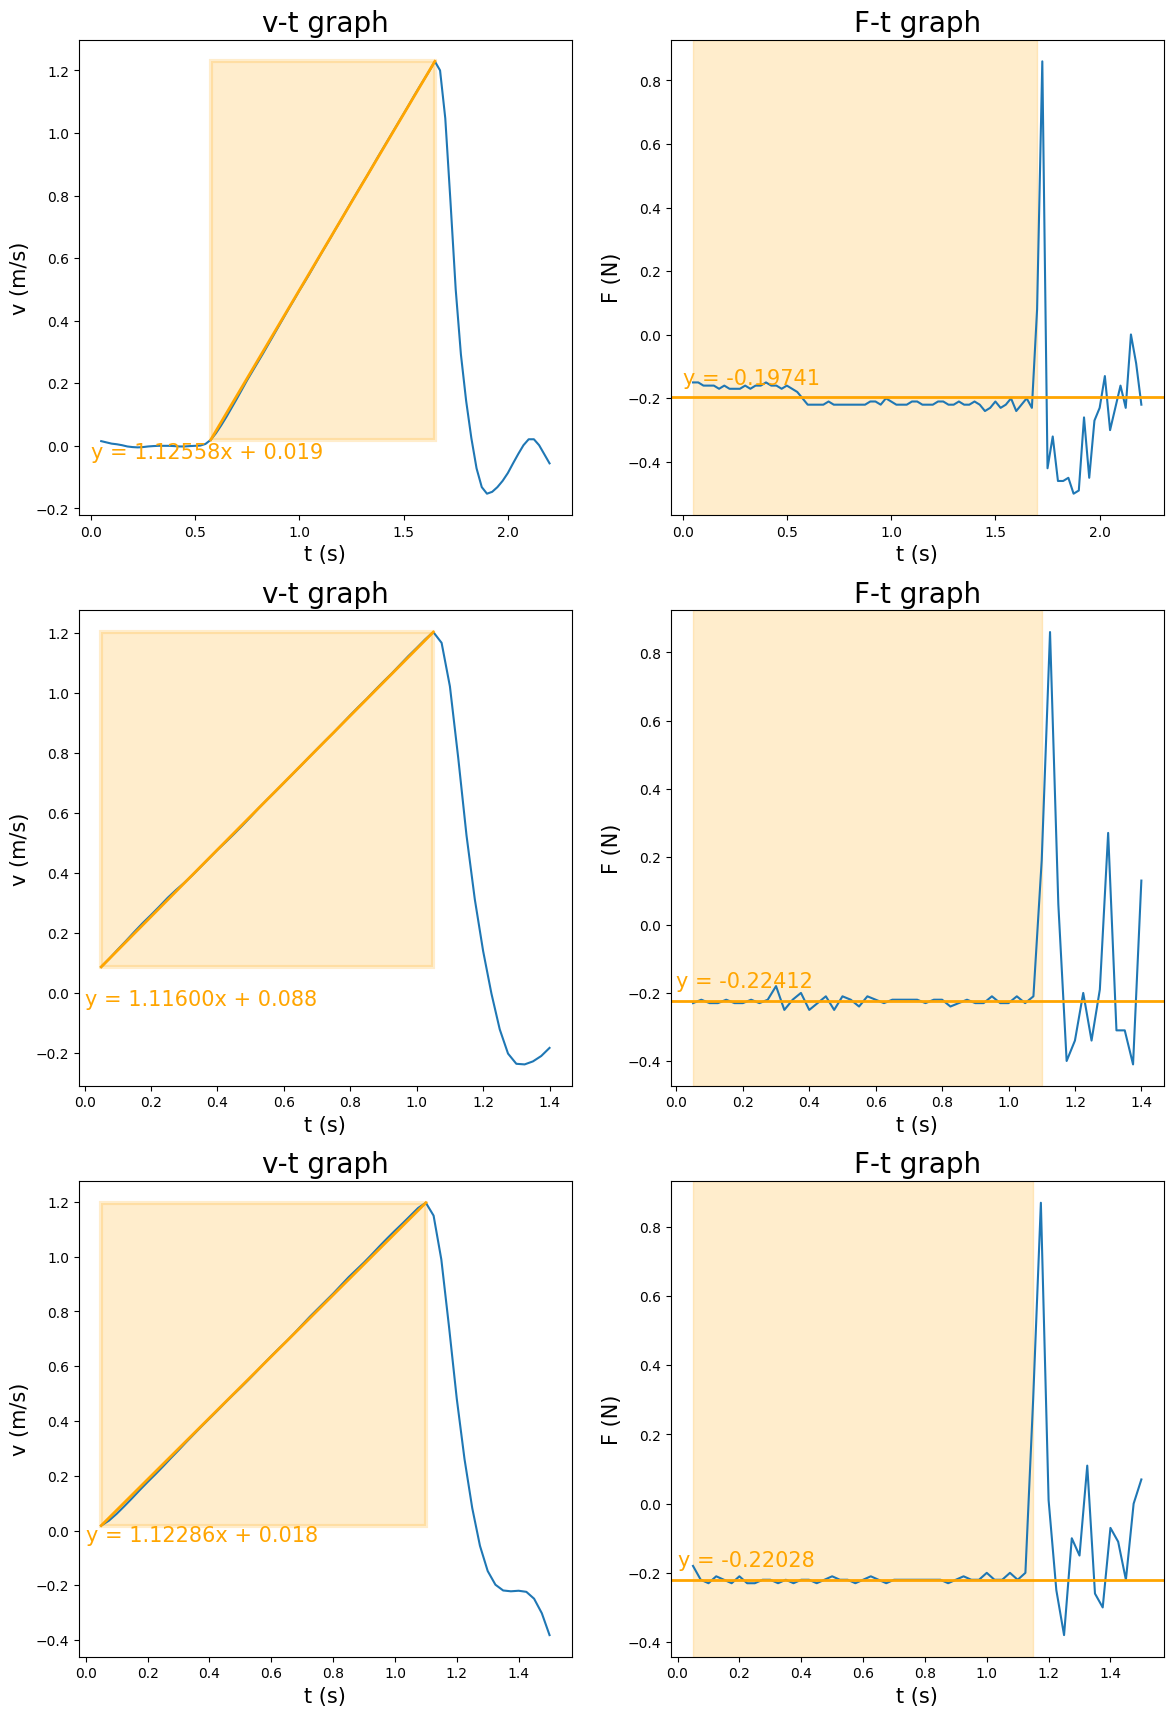

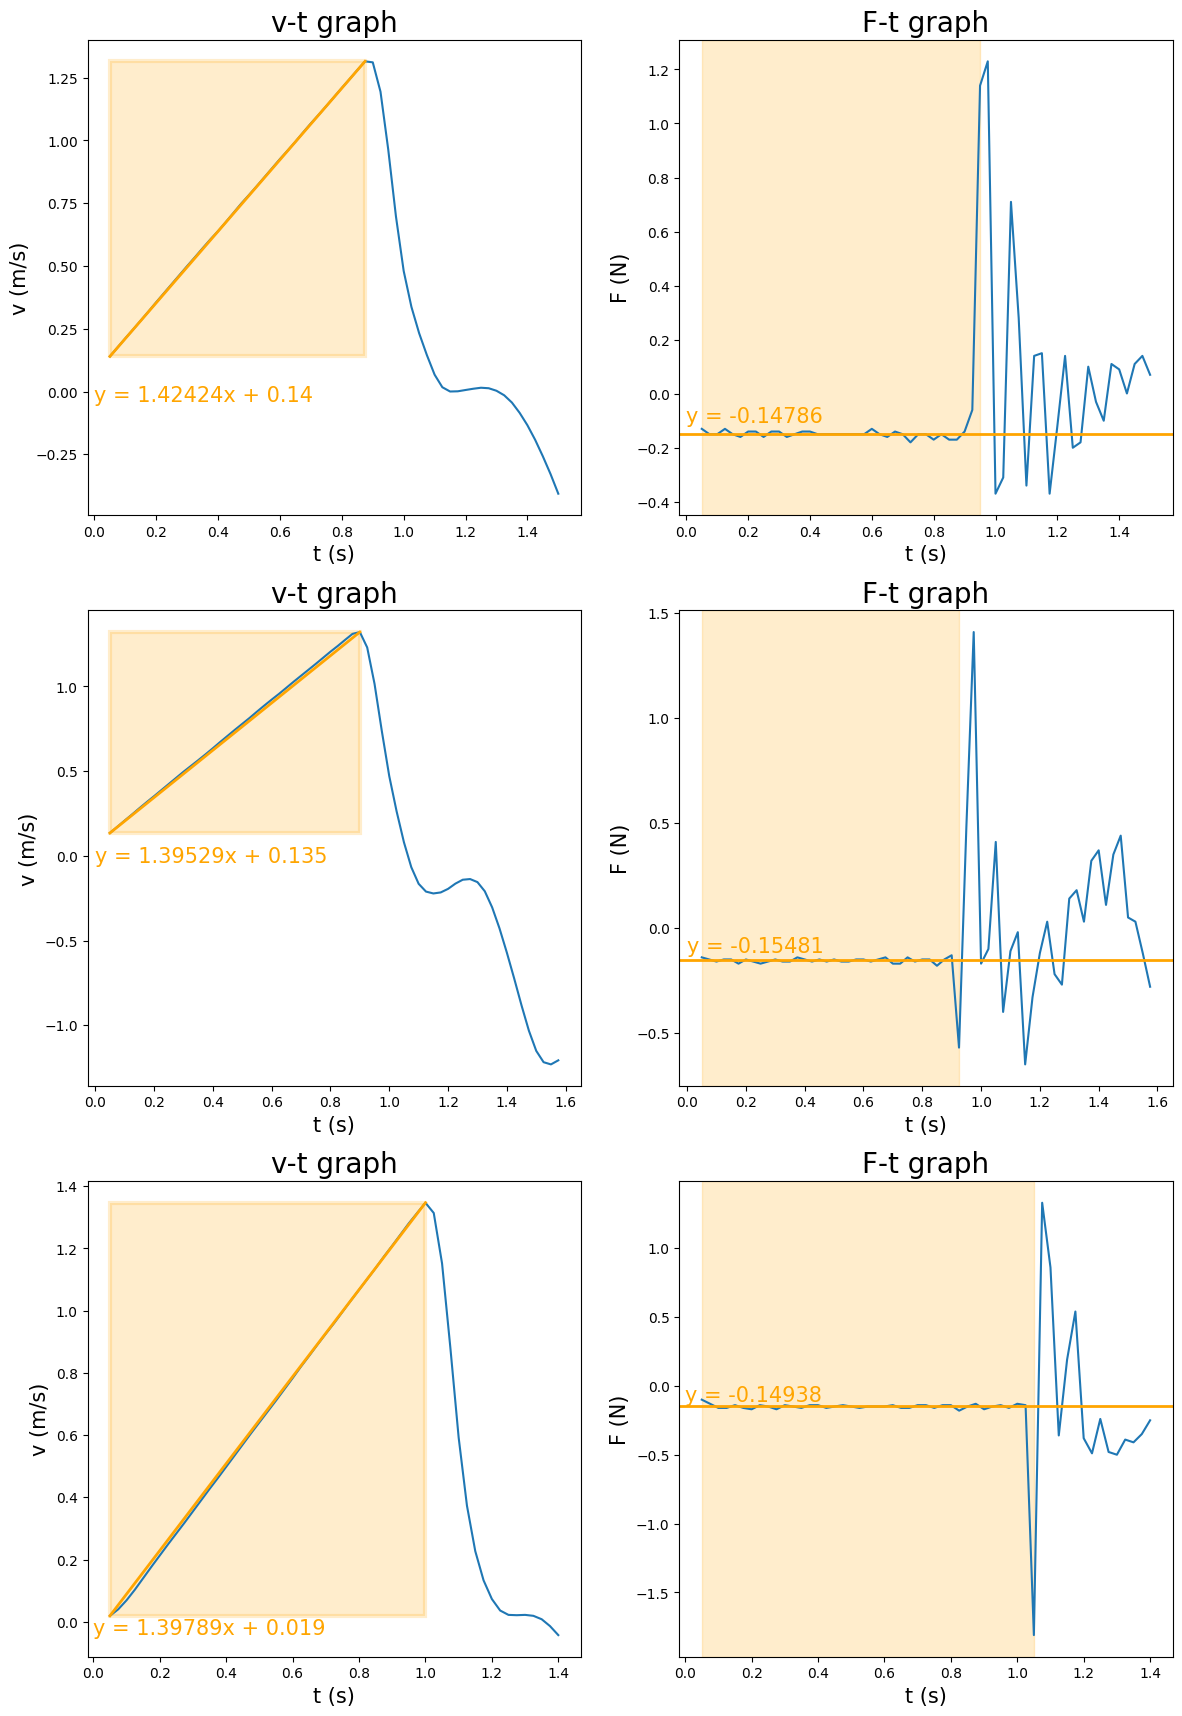

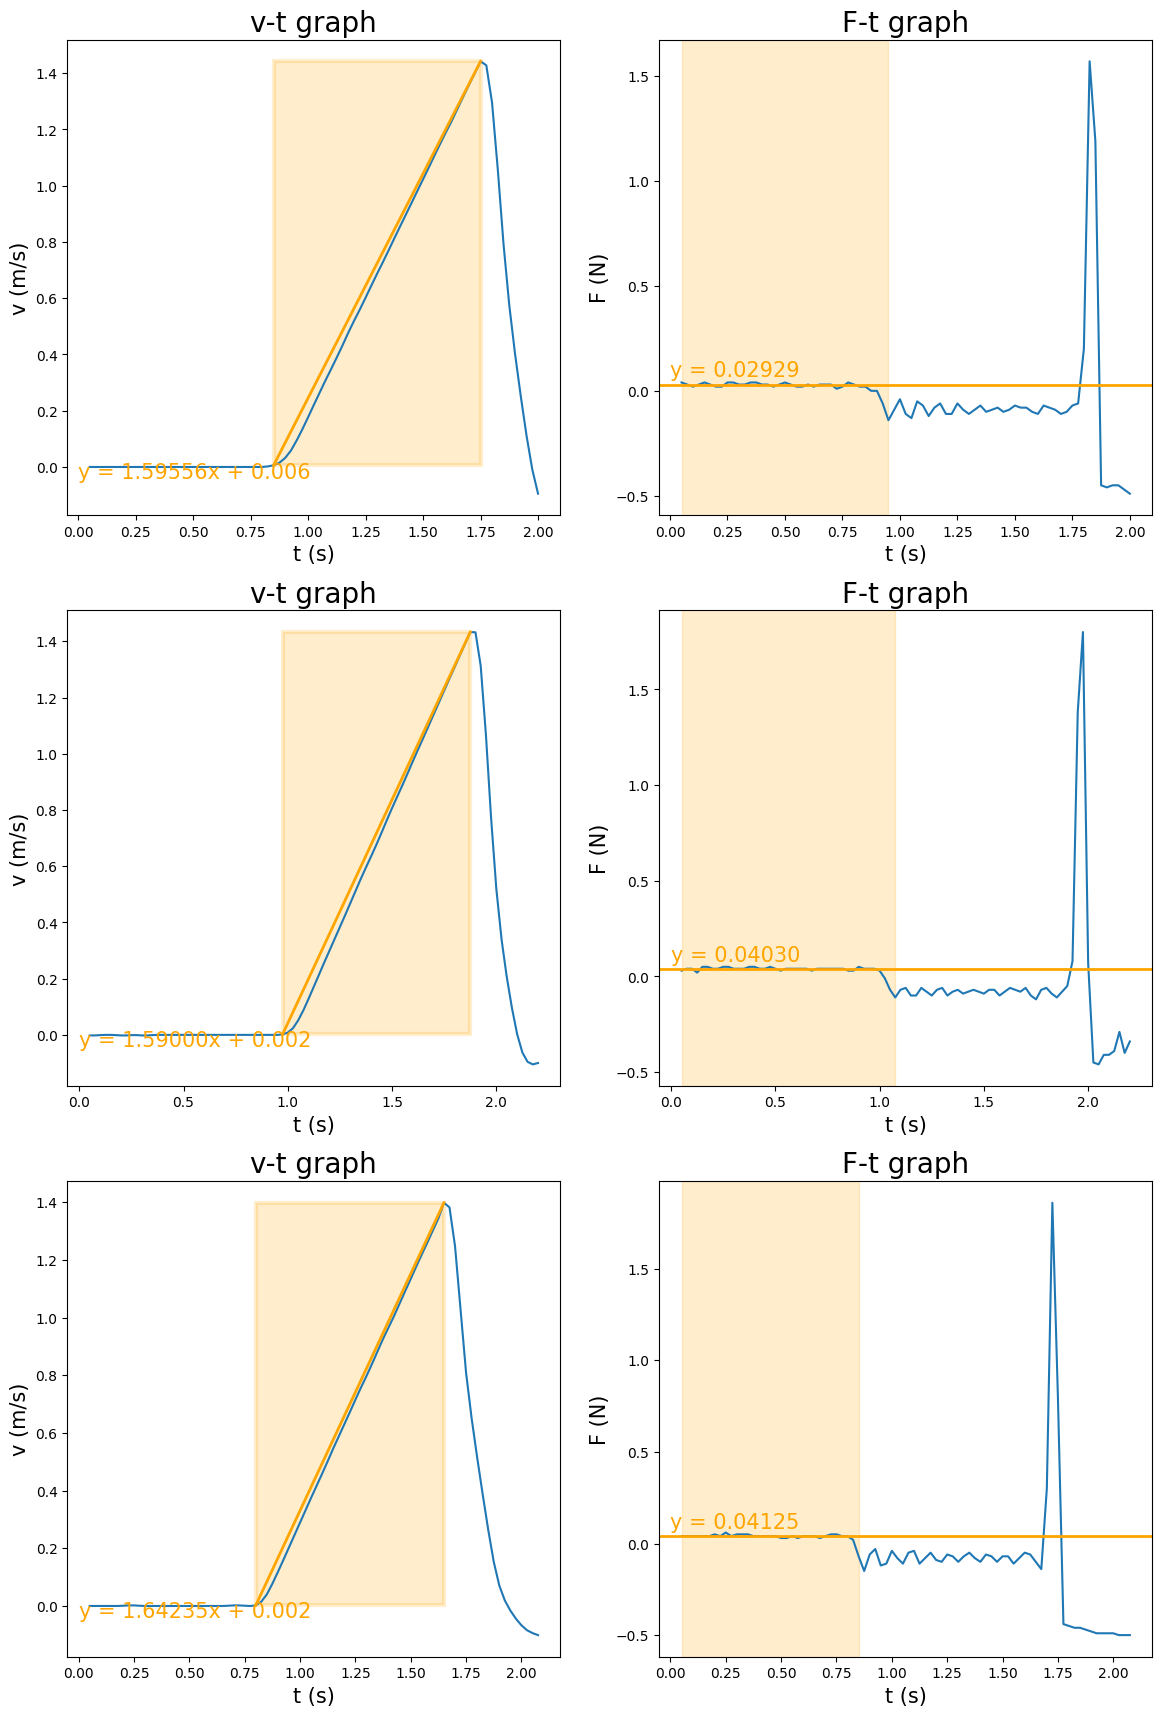

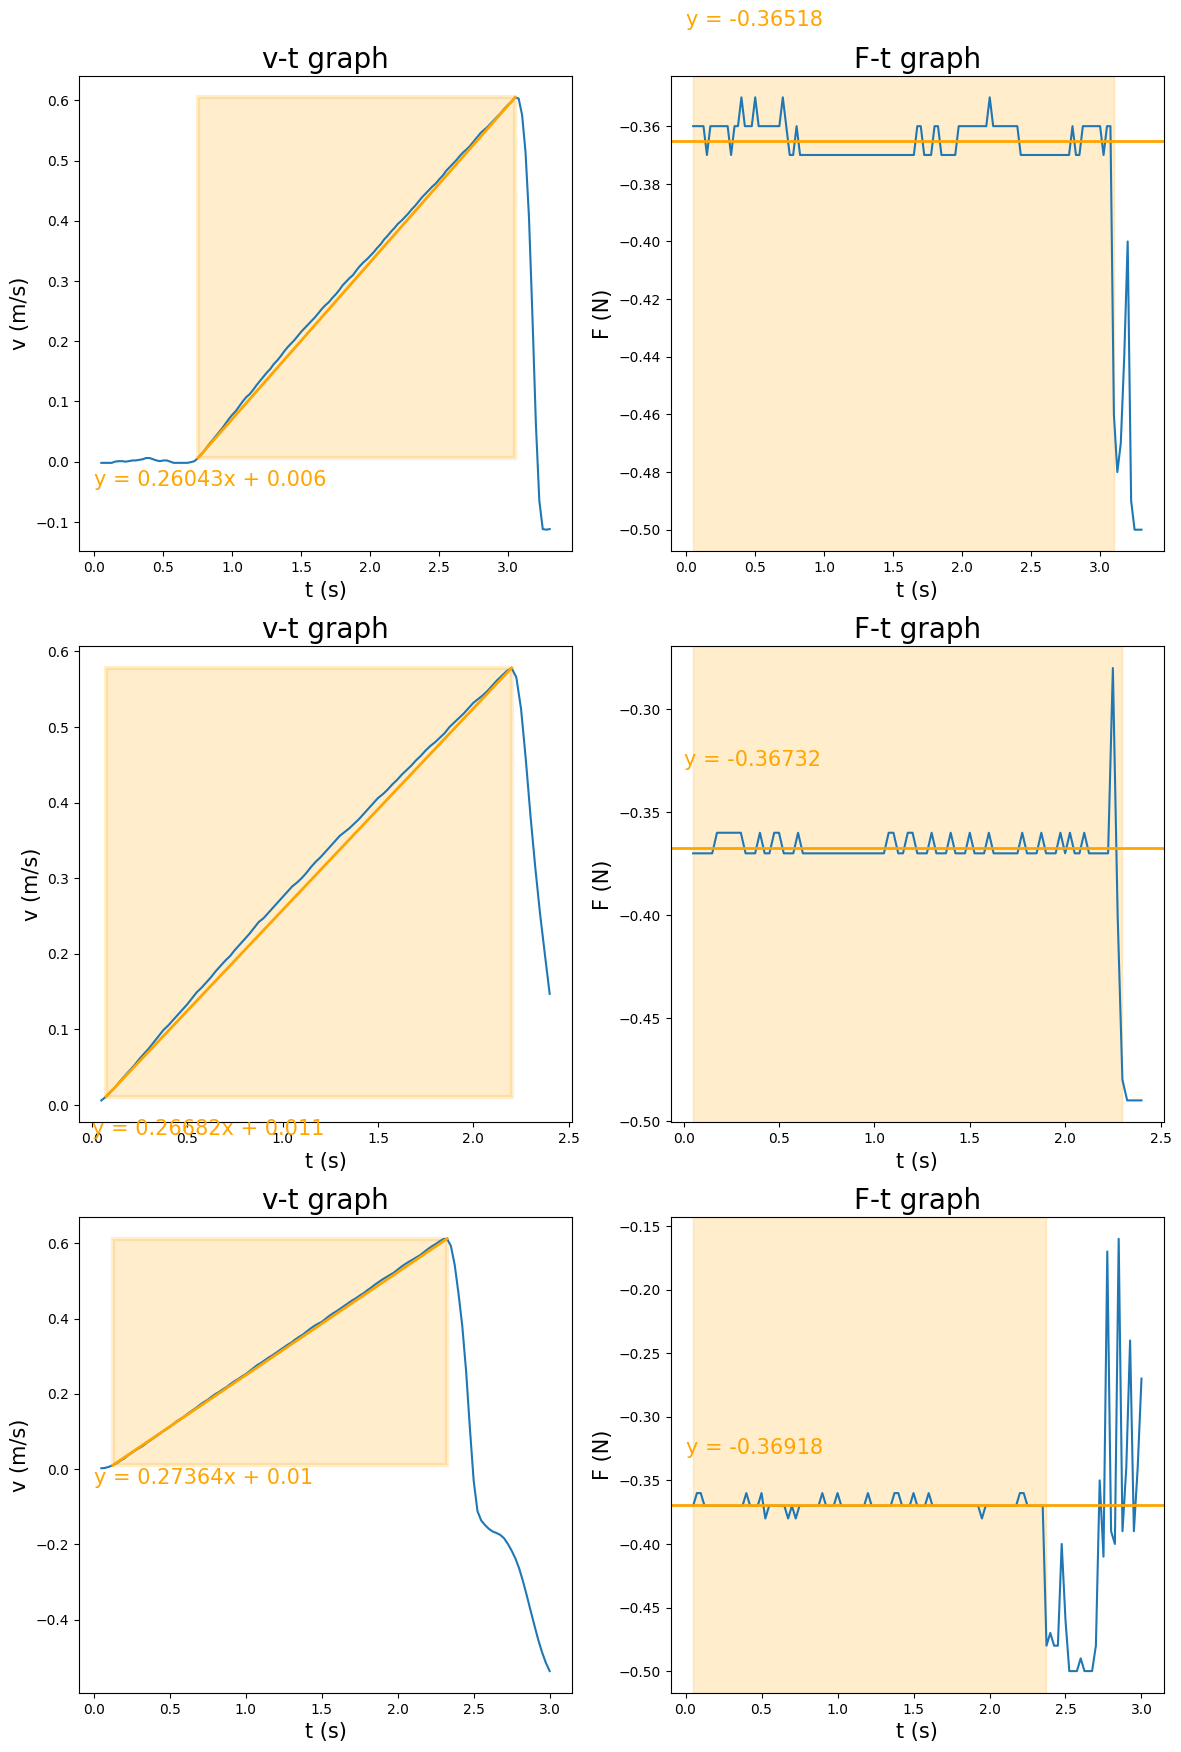

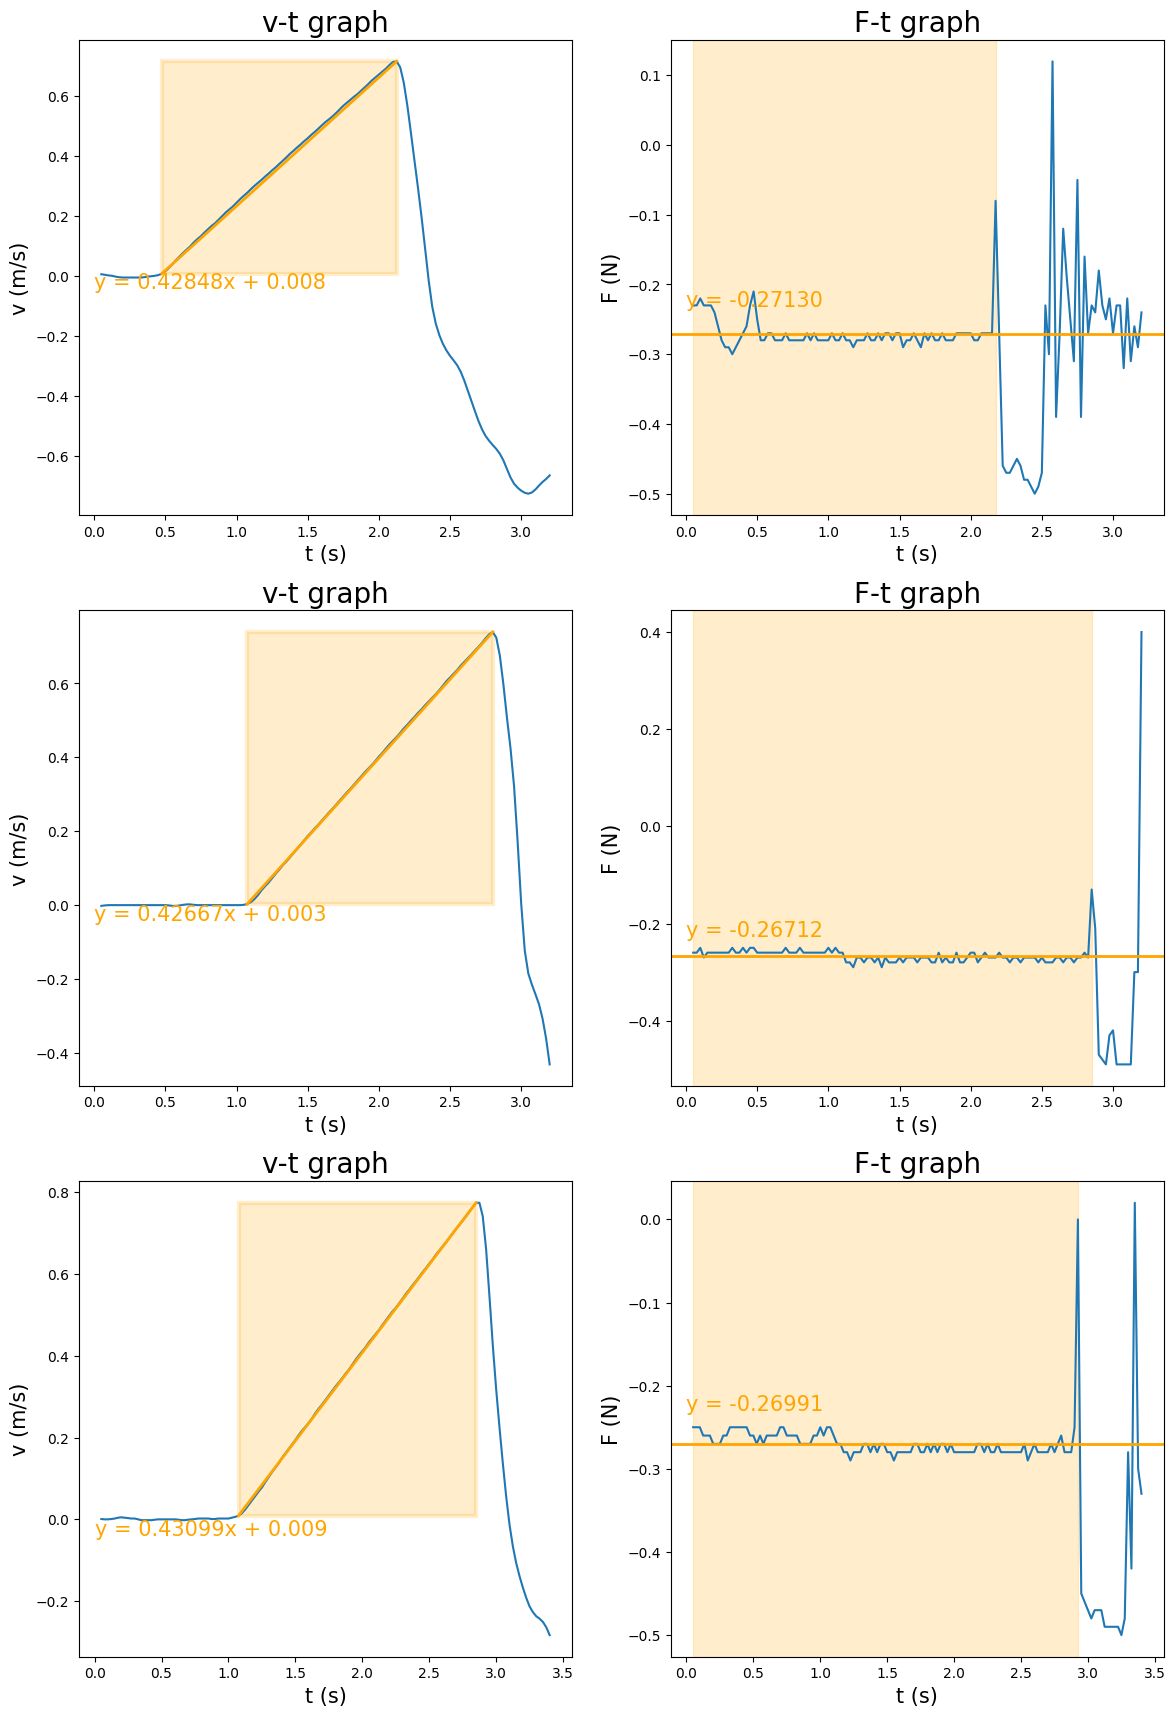

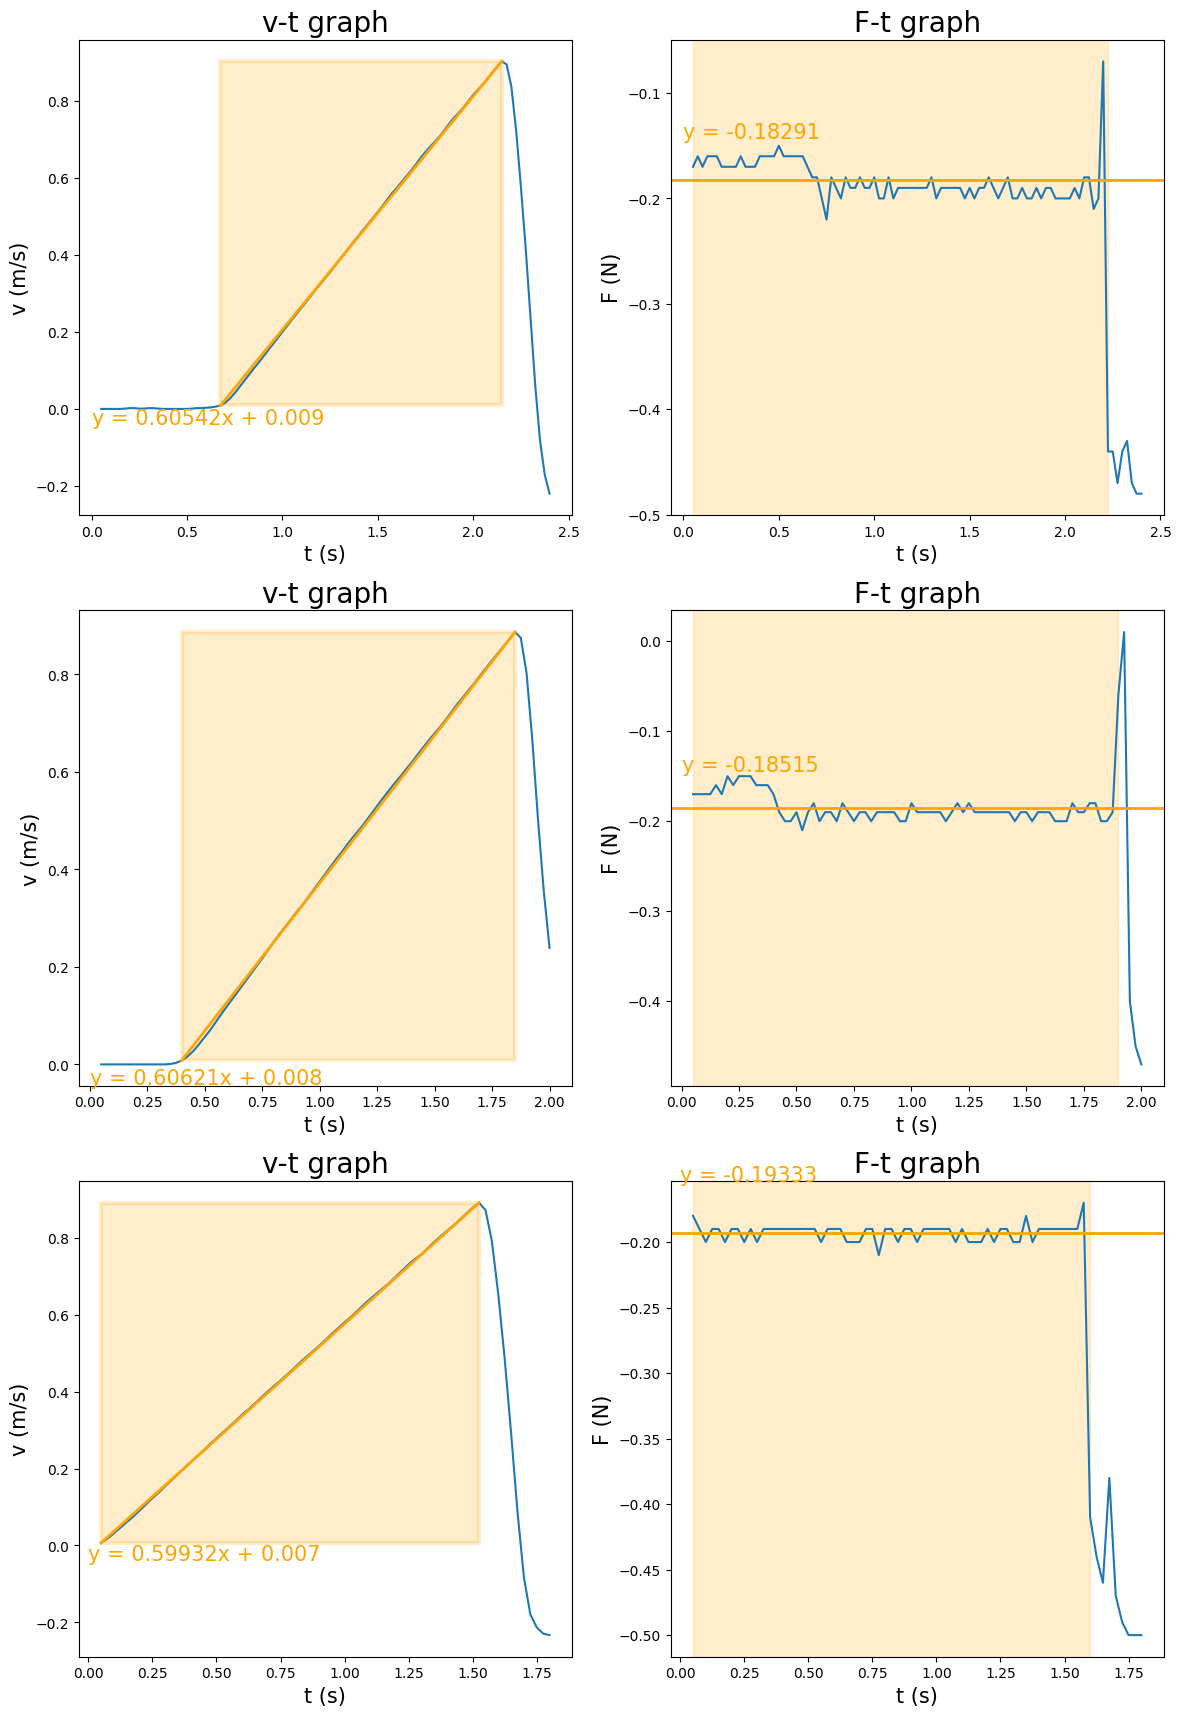

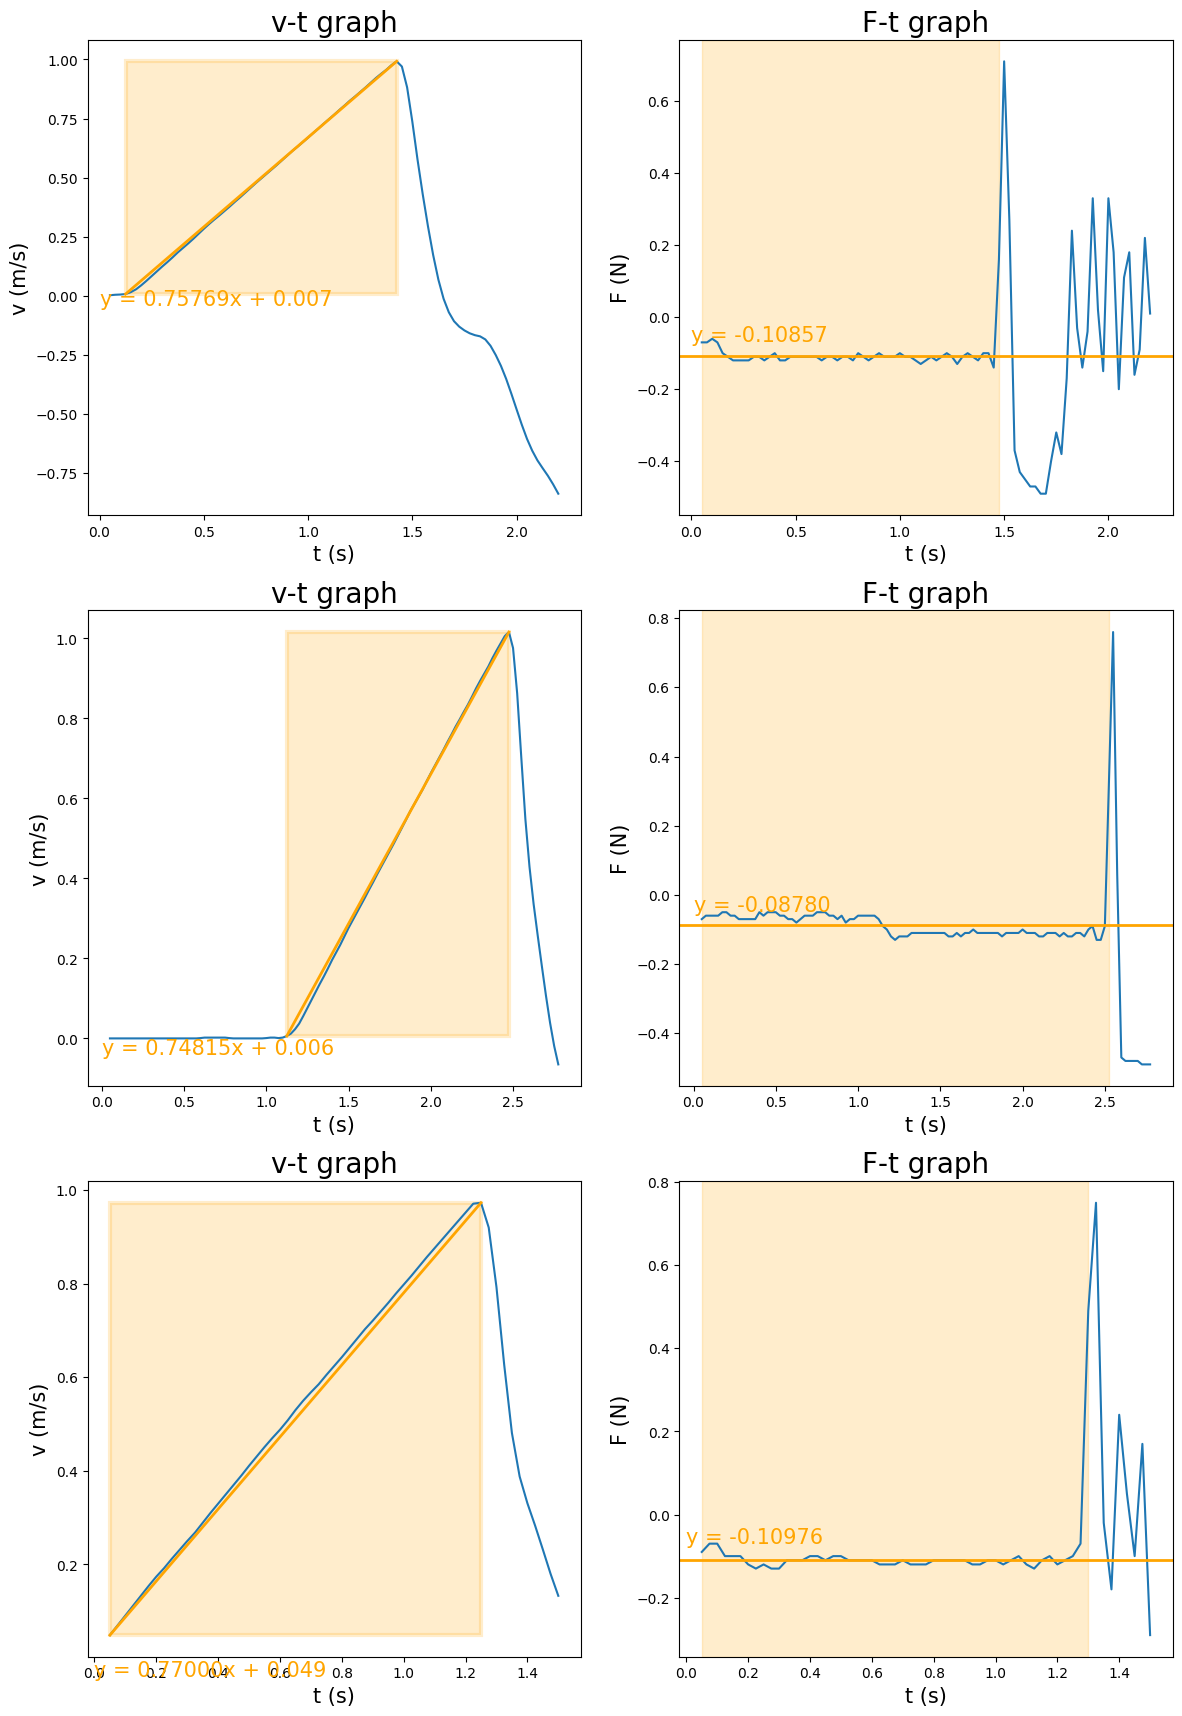

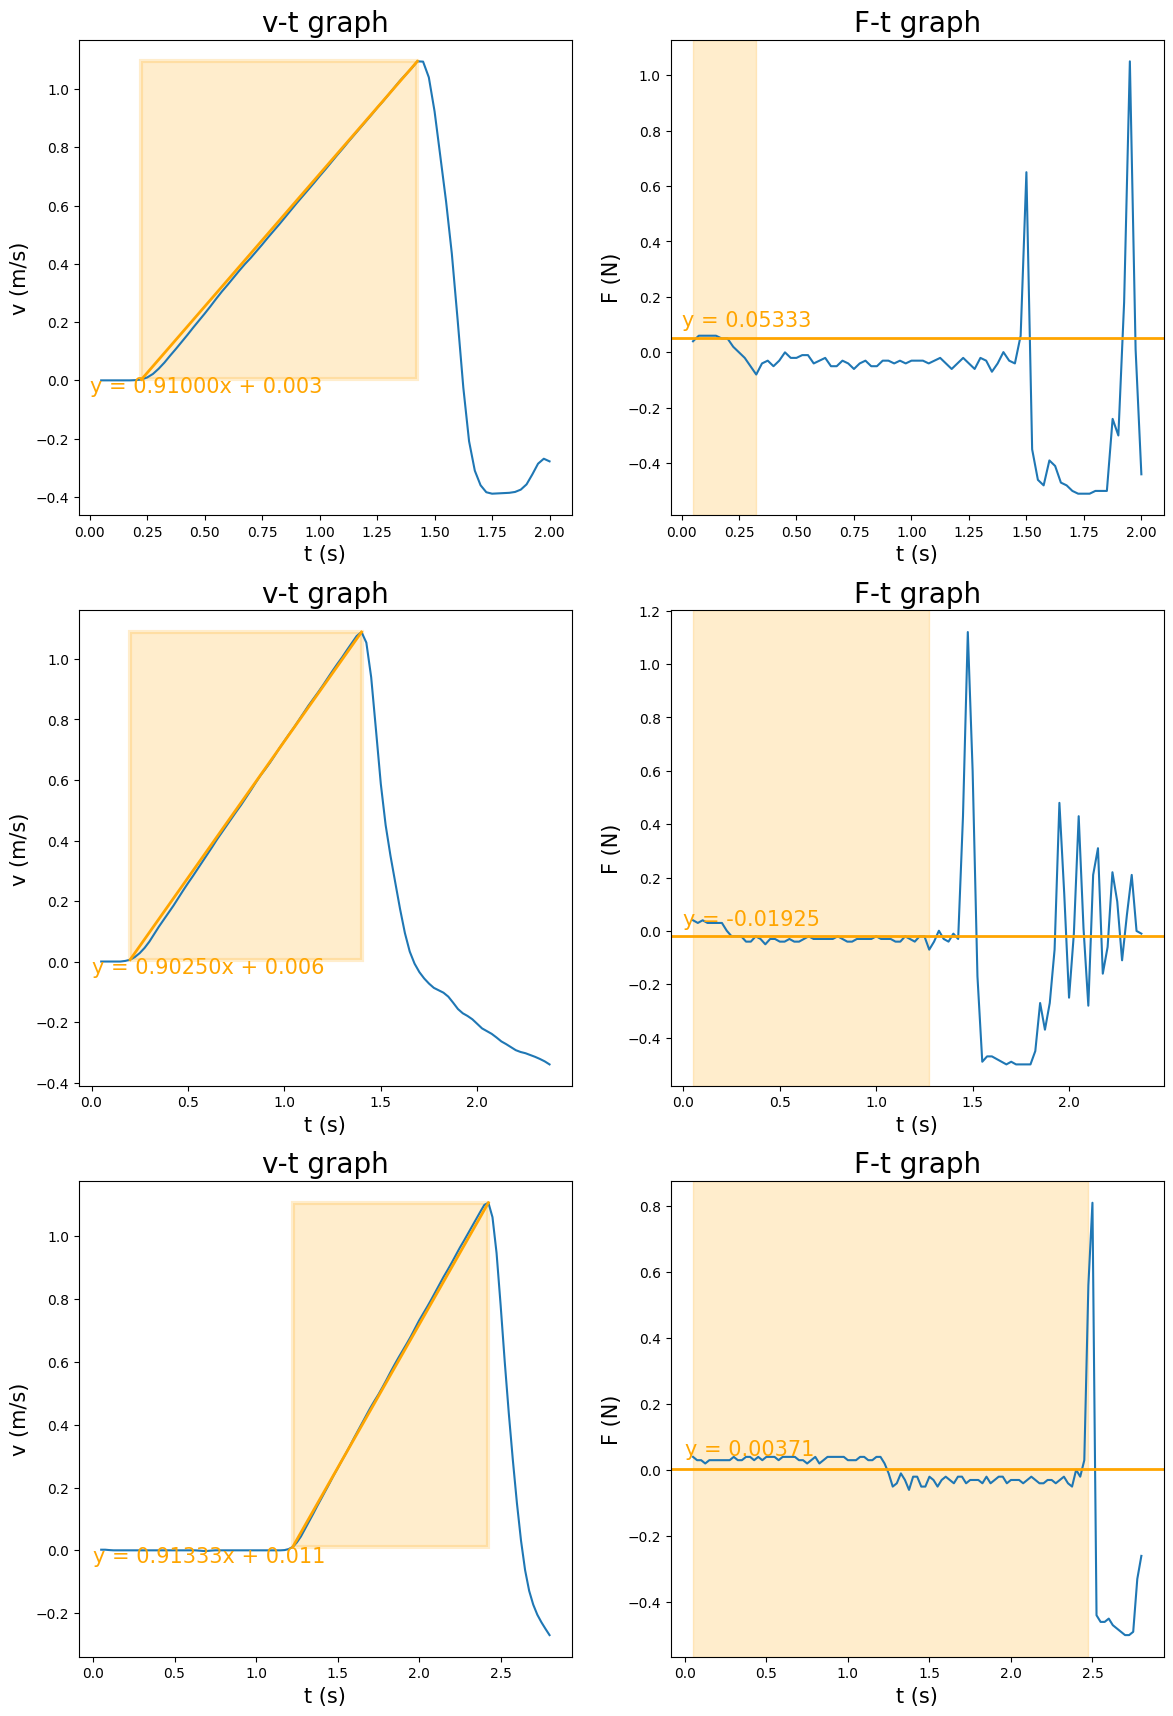

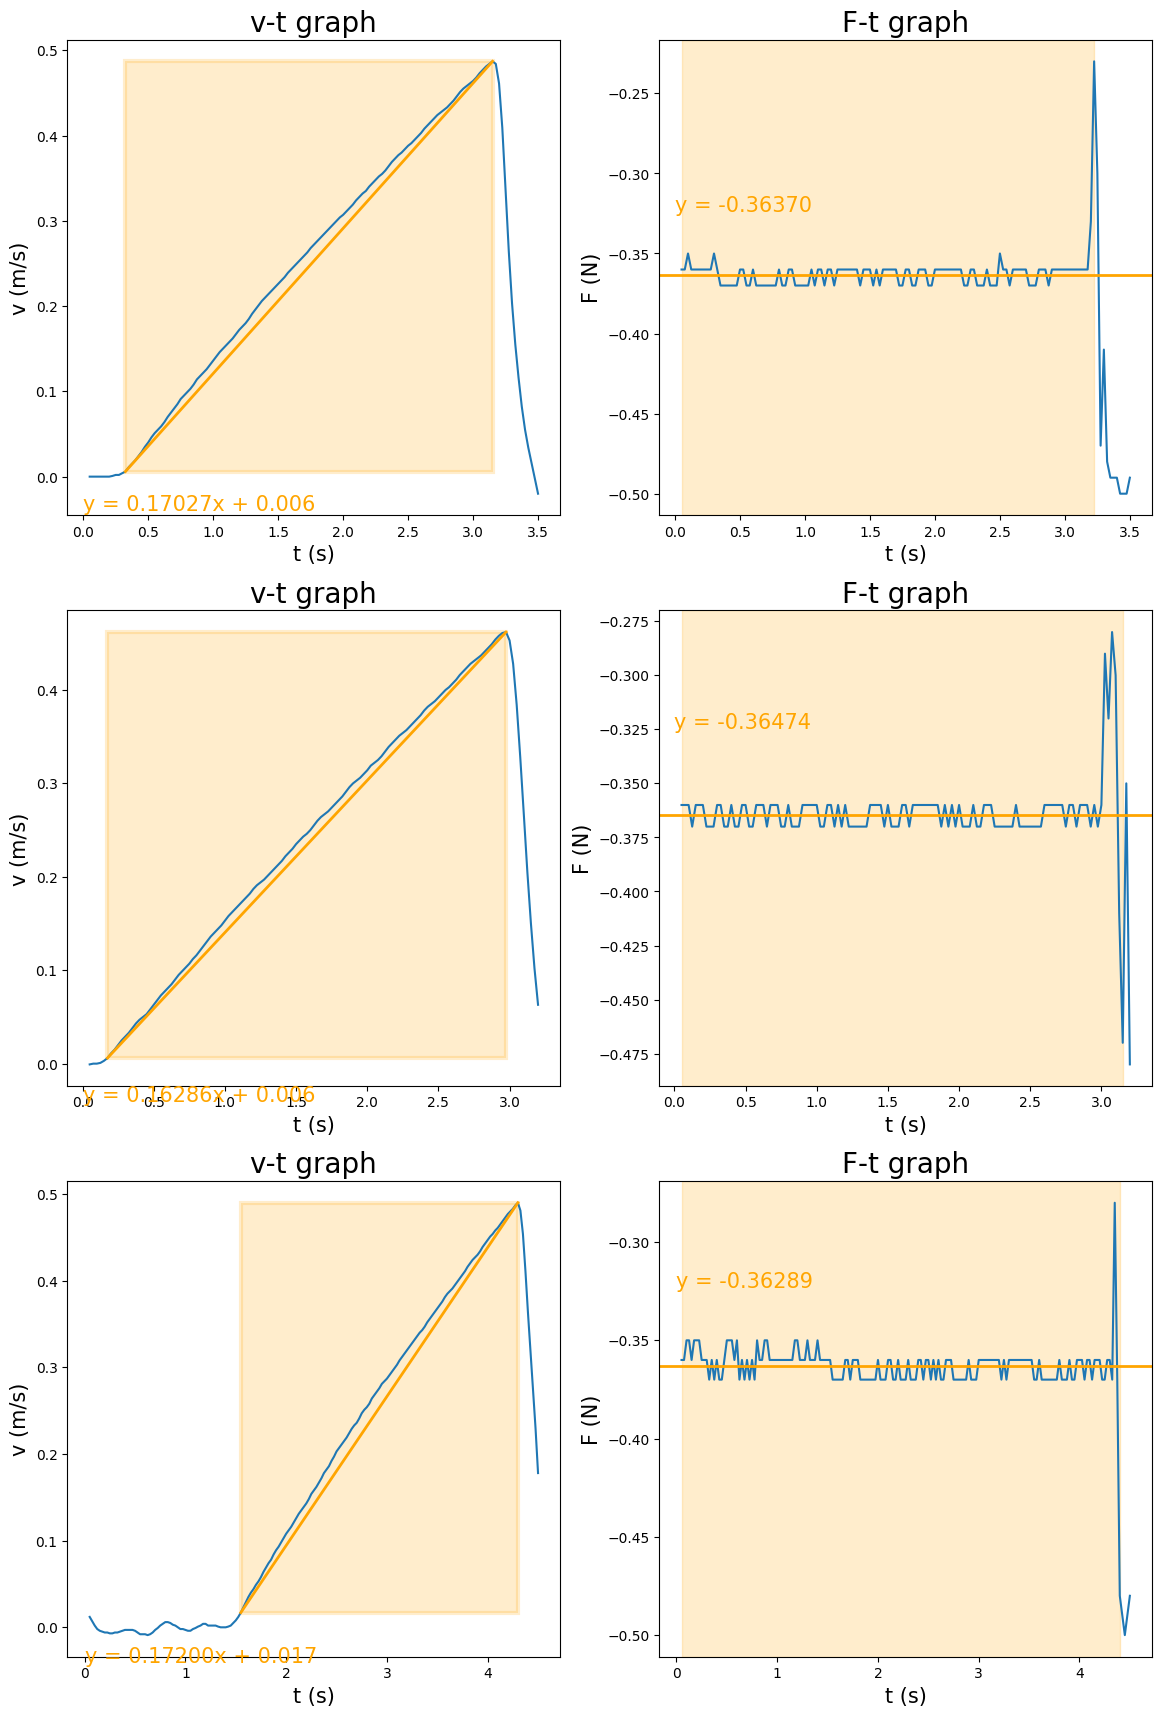

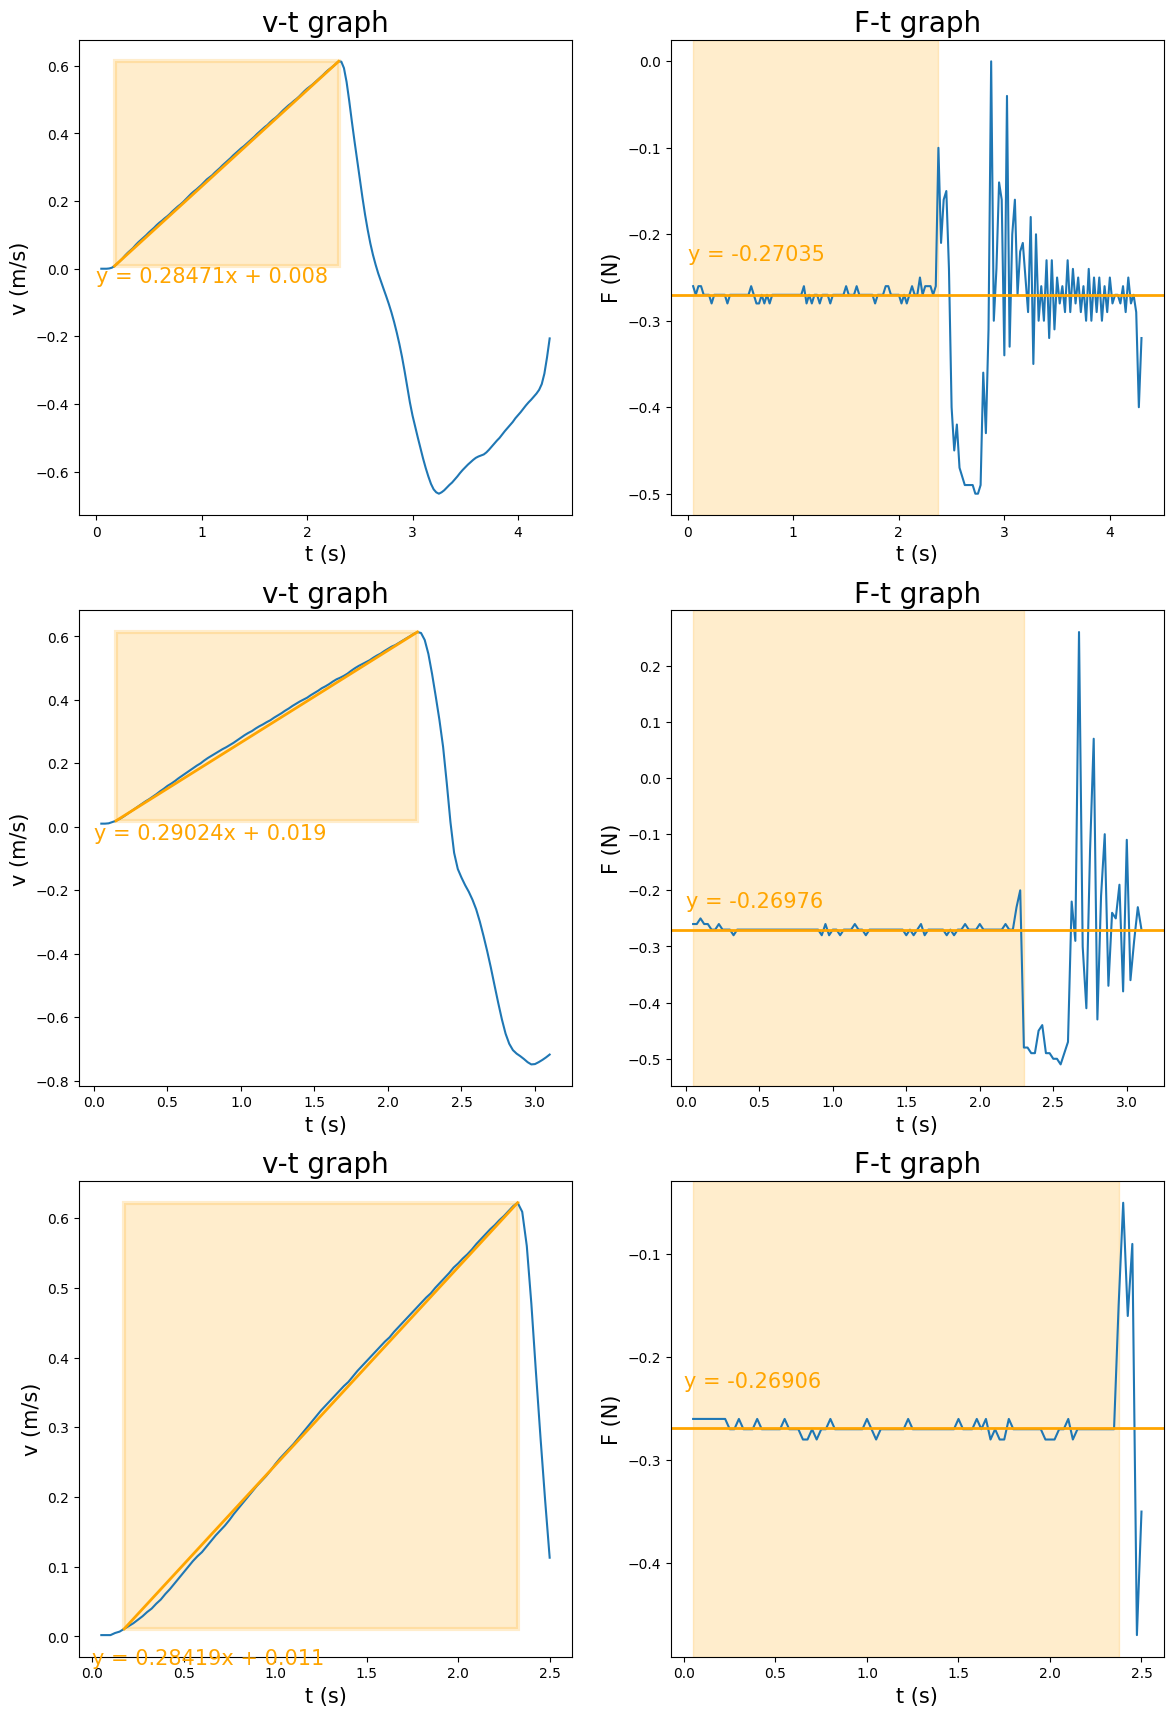

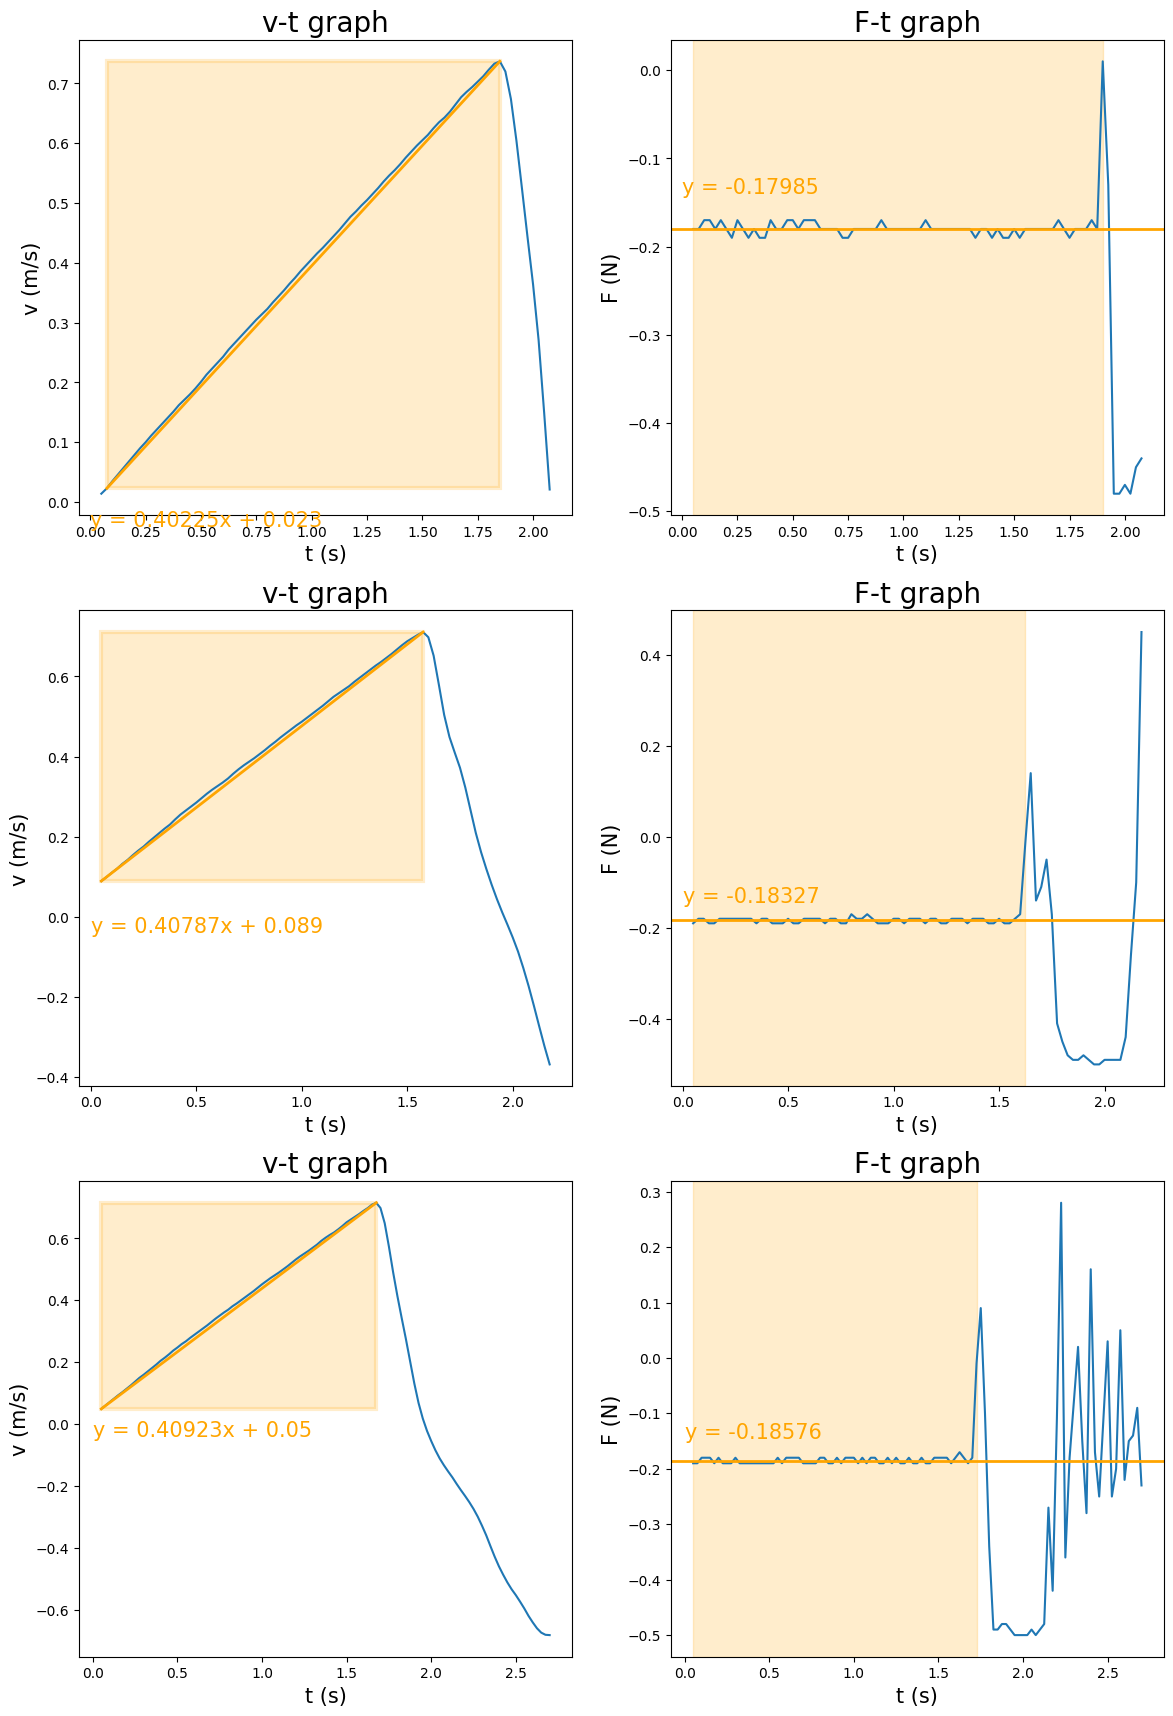

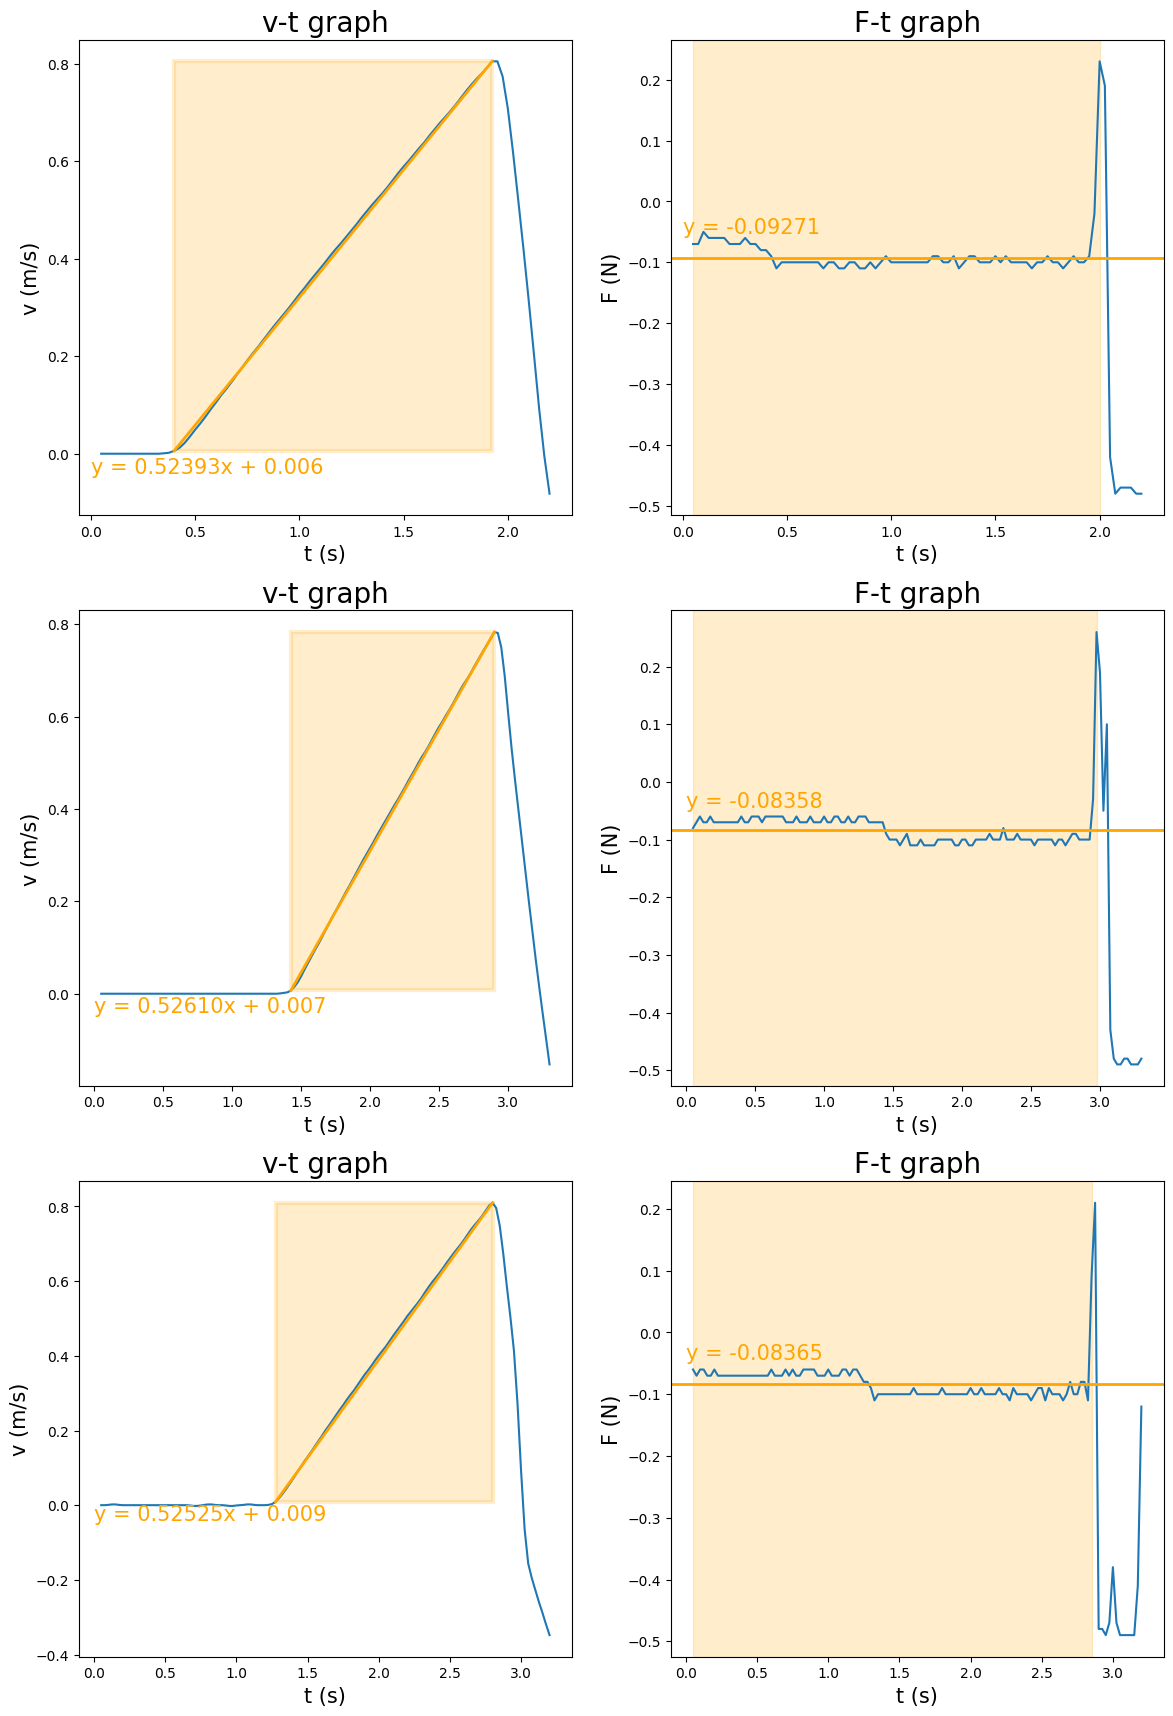

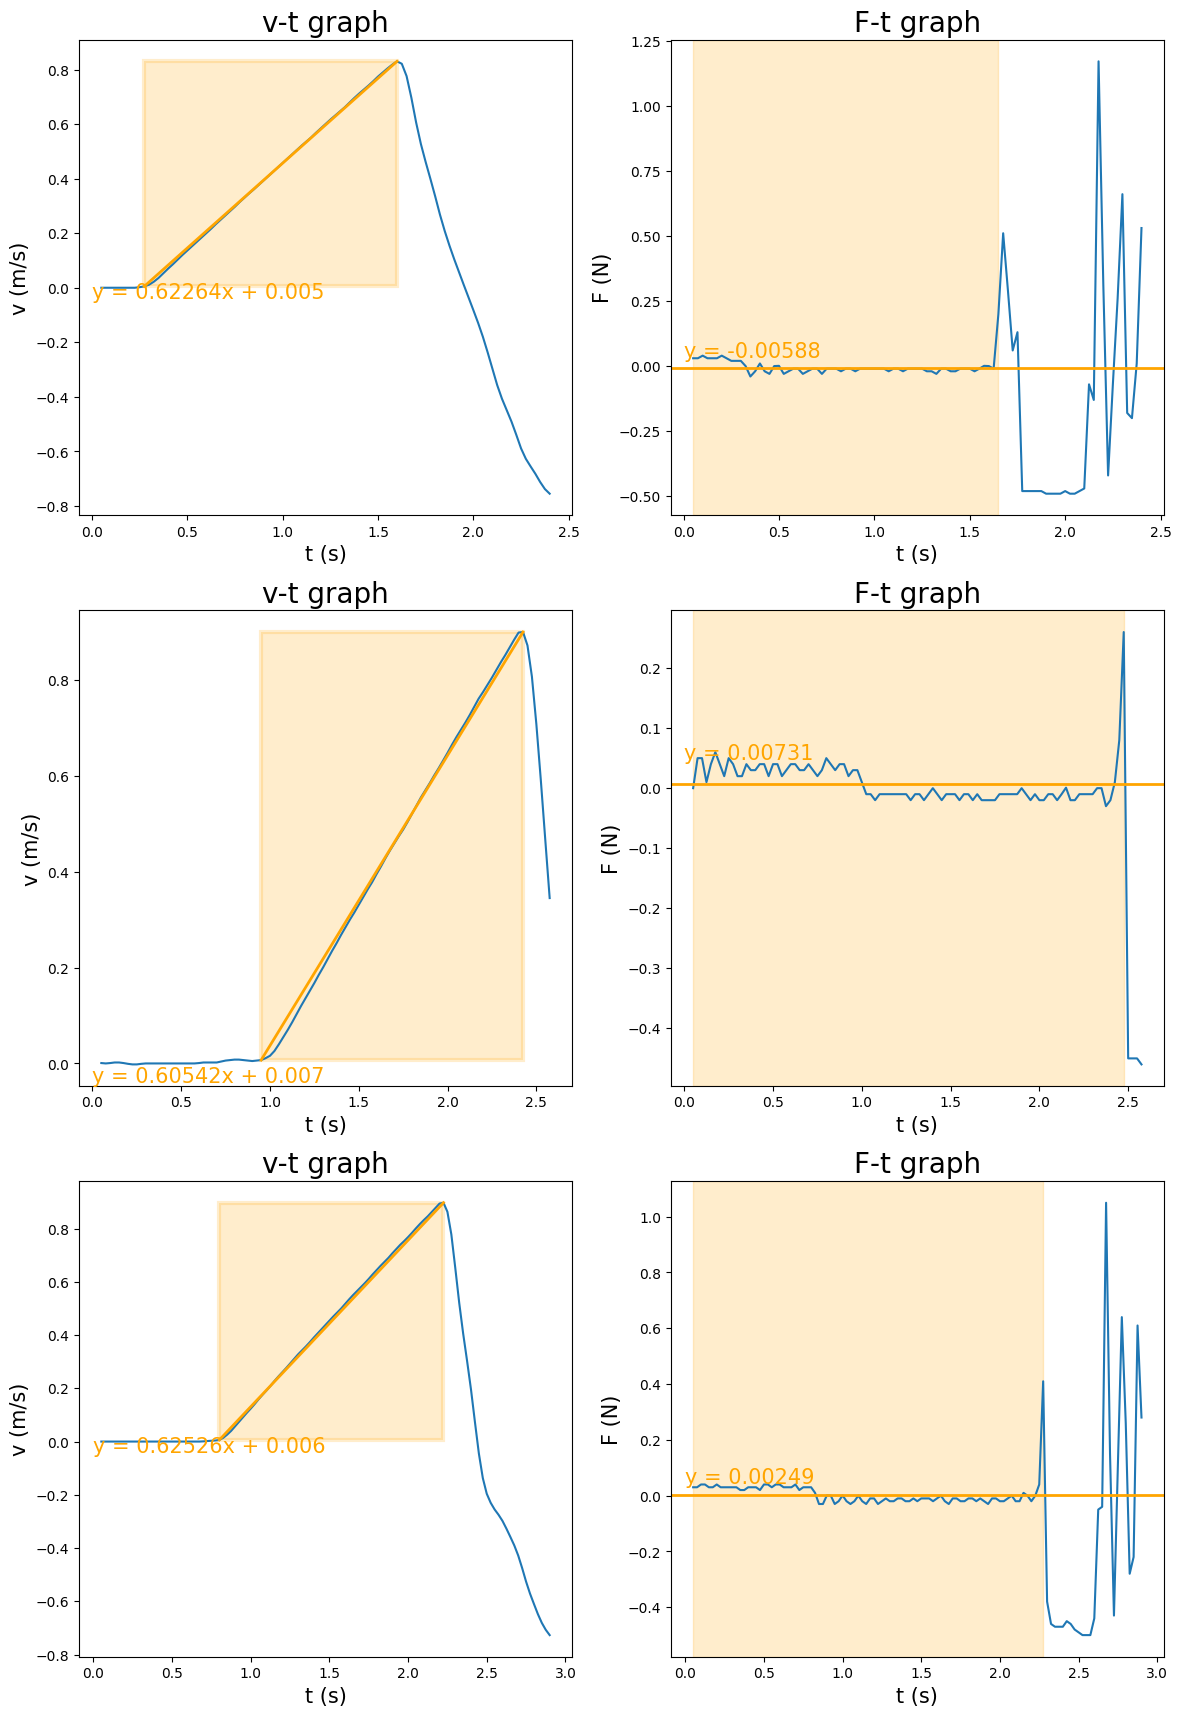

In [27]:
plot = get(runs, massbar=2, weight=30)

ret = pd.DataFrame(columns=['N', 'a'])
for i in range(3):
    for j in range(10, 60, 10):
        tmp = get(runs, massbar=i, weight=j).analyze(massbar=i, weight=j)
        ret = pd.concat([ret, tmp])
        
ret

In [28]:
ret.to_excel("./data/result.xlsx")

ret

,N,a
1,-0.379375,0.491831
2,-0.373165,0.512727
3,-0.375962,0.517931
4,-0.294444,0.835238
5,-0.280685,0.805385
6,-0.289348,0.829600
7,-0.197414,1.125581
8,-0.224118,1.116000
9,-0.220278,1.122857
11,-0.147857,1.424242


In [29]:
import numpy as np
from sympy import *
from sympy.abc import *

g = 9.80665
μ = 0.0403 / g
r = 0.051 / 2
I = 7.25214E-08
F0 = -0.53689

ret['Corrected N'] = ret['N'] - F0

ret

,N,a,Corrected N
1,-0.379375,0.491831,0.157515
2,-0.373165,0.512727,0.163725
3,-0.375962,0.517931,0.160928
4,-0.294444,0.835238,0.242446
5,-0.280685,0.805385,0.256205
6,-0.289348,0.829600,0.247542
7,-0.197414,1.125581,0.339476
8,-0.224118,1.116000,0.312772
9,-0.220278,1.122857,0.316612
11,-0.147857,1.424242,0.389033


In [30]:
bar_masses = np.array((248.23, 252.84)) / 1000
weights = np.array((9.97, 9.95, 9.97, 20.2 - 9.97, 9.97)) / 1000
hook_mass = np.array(5.17) / 1000
cart_mass = np.array(251.01) / 1000

expected_a = pd.Series()
expected_T1 = pd.Series()
expected_T2 = pd.Series()
expected_a_tmp = pd.Series()
expected_T_tmp = pd.Series()

string_mass = 0.05 / 1000

for i, run_id in enumerate(ret.index):
    massbar_count = i // 15
    weight_count = (i // 3) % 5 + 1

    M = cart_mass + sum(bar_masses[:massbar_count])
    m = hook_mass + sum(weights[:weight_count]) + string_mass

    a = ((m - μ*M) / (M + m + I/r**2)) * g
    T1 = M*(a + μ*g)
    T2 = m*(g - a)

    a_tmp = ((m - μ*M) / (M + m)) * g
    T_tmp = M*(a + μ*g)

    expected_a[run_id] = a
    expected_T1[run_id] = T1
    expected_T2[run_id] = T2
    expected_a_tmp[run_id] = a_tmp
    expected_T_tmp[run_id] = T_tmp

ret['Expected a'] = expected_a
ret['Expected T1'] = expected_T1
ret['Expected T2'] = expected_T2
ret['Expected a_tmp'] = expected_a_tmp
ret['Expected T_tmp'] = expected_T_tmp

ret.to_excel("./data/result.xlsx")

ret

,N,a,Corrected N,Expected a,Expected T1,Expected T2,Expected a_tmp,Expected T_tmp
1,-0.379375,0.491831,0.157515,0.521372,0.140985,0.141043,0.521590,0.140985
2,-0.373165,0.512727,0.163725,0.521372,0.140985,0.141043,0.521590,0.140985
3,-0.375962,0.517931,0.160928,0.521372,0.140985,0.141043,0.521590,0.140985
4,-0.294444,0.835238,0.242446,0.855796,0.224929,0.225024,0.856142,0.224929
5,-0.280685,0.805385,0.256205,0.855796,0.224929,0.225024,0.856142,0.224929
6,-0.289348,0.829600,0.247542,0.855796,0.224929,0.225024,0.856142,0.224929
7,-0.197414,1.125581,0.339476,1.167572,0.303188,0.303318,1.168027,0.303188
8,-0.224118,1.116000,0.312772,1.167572,0.303188,0.303318,1.168027,0.303188
9,-0.220278,1.122857,0.316612,1.167572,0.303188,0.303318,1.168027,0.303188
11,-0.147857,1.424242,0.389033,1.465680,0.378016,0.378180,1.466232,0.378016


In [31]:
ret['Error a'] = (ret['a'] - ret['Expected a']) / ret['Expected a'] * 100
ret['Error N'] = (ret['Corrected N'] - ret['Expected T1']) / ret['Expected T1'] * 100
ret['Error a_tmp'] = (ret['Expected a_tmp'] - ret['Expected a']) / ret['Expected a'] * 100
ret['Error N_tmp'] = (ret['Expected T_tmp'] - ret['Expected T1']) / ret['Expected T1'] * 100

ret.to_excel("./data/result.xlsx")

ret

,N,a,Corrected N,Expected a,Expected T1,Expected T2,Expected a_tmp,Expected T_tmp,Error a,Error N,Error a_tmp,Error N_tmp
1,-0.379375,0.491831,0.157515,0.521372,0.140985,0.141043,0.521590,0.140985,-5.665971,11.724470,0.041897,0.0
2,-0.373165,0.512727,0.163725,0.521372,0.140985,0.141043,0.521590,0.140985,-1.658028,16.129501,0.041897,0.0
3,-0.375962,0.517931,0.160928,0.521372,0.140985,0.141043,0.521590,0.140985,-0.659937,14.145619,0.041897,0.0
4,-0.294444,0.835238,0.242446,0.855796,0.224929,0.225024,0.856142,0.224929,-2.402183,7.787580,0.040387,0.0
5,-0.280685,0.805385,0.256205,0.855796,0.224929,0.225024,0.856142,0.224929,-5.890571,13.904849,0.040387,0.0
6,-0.289348,0.829600,0.247542,0.855796,0.224929,0.225024,0.856142,0.224929,-3.060996,10.053459,0.040387,0.0
7,-0.197414,1.125581,0.339476,1.167572,0.303188,0.303318,1.168027,0.303188,-3.596364,11.968943,0.038980,0.0
8,-0.224118,1.116000,0.312772,1.167572,0.303188,0.303318,1.168027,0.303188,-4.416990,3.161250,0.038980,0.0
9,-0.220278,1.122857,0.316612,1.167572,0.303188,0.303318,1.168027,0.303188,-3.829690,4.427748,0.038980,0.0
11,-0.147857,1.424242,0.389033,1.465680,0.378016,0.378180,1.466232,0.378016,-2.827208,2.914361,0.037634,0.0


In [32]:
ret['Error a'].abs().mean(), ret['Error N'].abs().mean()

(3.546972407819037, 11.25284122900132)

In [33]:
ret['Error a_tmp'].abs().mean(), ret['Error N_tmp'].abs().mean()

(0.024704727946954805, 0.0)

In [34]:
runs.indexes

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

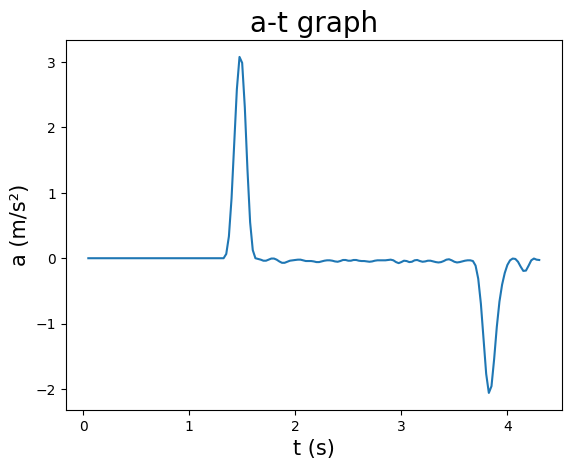

[]

In [35]:
runs[51].plot(x='t', y='a')